# Mid Semester Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

## Dependencies

In [1]:
!pip install minigrid
!pip install pyvirtualdisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 3.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import gymnasium as gym
import minigrid
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time

# additional imports
from abc import ABC, abstractmethod
from collections import defaultdict
from typing import Dict, Any, DefaultDict, List, Tuple


### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [3]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# 🚧 Assignment: Learning to Navigate with Dynamic Obstacles

## 🤖 Reinforcement Learning Environments with Gym

This assignment uses environments from the **[Gym](https://www.gymlibrary.dev/index.html)** interface—one of the most widely used toolkits for developing and comparing reinforcement learning algorithms. Gym provides a standardized API for environment interaction, allowing RL agents to easily observe states, take actions, and receive rewards across a wide variety of tasks.

Gym environments expose:
- `observation_space`: The format/type of observations the agent receives.
- `action_space`: The available actions the agent can take.
- `step(action)`: Executes an action and returns the next observation, reward, done flag, and info.
- `reset()`: Resets the environment to its initial state.

Gym is modular and extensible, and many libraries—like MiniGrid—are built on top of it.

---

## 🌍 Environment Overview: `MiniGrid-Dynamic-Obstacles-NxN-v0`

This assignment focuses on solving the `MiniGrid-Dynamic-Obstacles` environment—a dynamic and partially observable grid world designed to challenge reinforcement learning agents with moving hazards.

### 🔎 What is MiniGrid?

[MiniGrid](https://github.com/Farama-Foundation/minigrid) is a lightweight and extensible benchmark suite for reinforcement learning, especially suited for testing agents in **partially observable**, **sparse reward**, and **goal-directed** settings. All environments are grid-based and allow agents to perceive the world from an egocentric, first-person perspective.

### 🧠 About the `Dynamic-Obstacles` Variant

In `MiniGrid-Dynamic-Obstacles-NxN-v0`, the agent is placed in a grid along with one or more **moving obstacles** and must reach a fixed **goal position** while avoiding collisions. These obstacles move according to predefined patterns and introduce **temporal dynamics** that make the task more challenging. This environment is ideal for evaluating an agent’s **robustness**, **reactivity**, and ability to perform **safe exploration** under uncertainty.

\
Comprehensive information about this environment can be found in the [official documentation](https://minigrid.farama.org/environments/minigrid/DynamicObstaclesEnv). Observations are represented as a grid of **tuples of three integers**, each encoding:
- The object type (`OBJECT_TO_IDX`)
- Its color (`COLOR_TO_IDX`)
- A state flag (relevant in some environments)

These mappings are defined in the subsection titled *Minigrid constant mapping*.

⚠️ **Note**: Unlike many other MiniGrid variants, this environment **does not include doors**, so the third value in the observation tuple (the `STATE` component) is **not relevant** for this assignment.


---

## 🎓 Assignment Objective

Your primary task is to implement and train **tabular reinforcement learning algorithms** to solve the `MiniGrid-Dynamic-Obstacles-6x6-v0` environment.

However, **the core objective of this assignment is not just training the agent**, but more importantly, to **clearly and thoughtfully communicate your findings**. You are expected to submit a concise and well-structured **$4$** pages report that documents the entire process—including the **challenges** faced, **design decisions**, **insights**, **limitations**, and any **unexpected behaviors** encountered along the way.

The quality and clarity of your report will be the **main factor** in determining your grade. The goal is to demonstrate deep understanding, critical thinking, and the ability to reflect on the agent's behavior and learning dynamics in a dynamic environment.

---




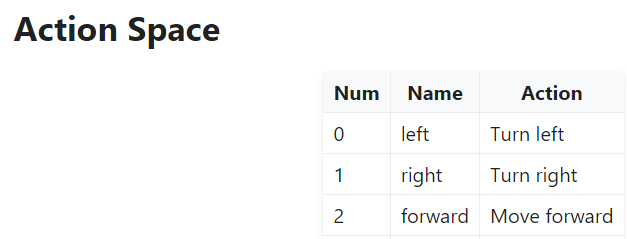

### Observation Space (taken from the `5*5` environment)

<div align="center">
  <img src="https://minigrid.farama.org/_images/DynamicObstaclesEnv.gif" alt="Dynamic Obstacles" width="600"/>
</div>


### Minigrud constant mapping:

In [4]:
COLORS = {
    "red": np.array([255, 0, 0]),
    "green": np.array([0, 255, 0]),
    "blue": np.array([0, 0, 255]),
    "purple": np.array([112, 39, 195]),
    "yellow": np.array([255, 255, 0]),
    "grey": np.array([100, 100, 100]),
}

COLOR_NAMES = sorted(list(COLORS.keys()))

# Used to map colors to integers
COLOR_TO_IDX = {"red": 0, "green": 1, "blue": 2, "purple": 3, "yellow": 4, "grey": 5}

IDX_TO_COLOR = dict(zip(COLOR_TO_IDX.values(), COLOR_TO_IDX.keys()))

# Map of object type to integers
OBJECT_TO_IDX = {
    "unseen": 0,
    "empty": 1,
    "wall": 2,
    "floor": 3,
    "door": 4,
    "key": 5,
    "ball": 6,
    "box": 7,
    "goal": 8,
    "lava": 9,
    "agent": 10,
}

IDX_TO_OBJECT = dict(zip(OBJECT_TO_IDX.values(), OBJECT_TO_IDX.keys()))

# Map of state names to integers
STATE_TO_IDX = {
    "open": 0,
    "closed": 1,
    "locked": 2,
}

### Environment setup

In [5]:
# Create the Dynamic-Obstacles environment (6x6 size)
# `render_mode="rgb_array"` allows visual rendering if needed
env = gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0", render_mode="rgb_array")
print(f"MaxSteps: {env.unwrapped.max_steps}") # The maximum number of steps allowed before the episode is truncated (i.e., ends without reaching a terminal state)


# Display the structure of the observation and action spaces
print(f"Observation space: {env.observation_space}")  # A dictionary; we will focus on the 'image' key
print(f"Action space: {env.action_space}")            # Discrete action set (e.g., turn, move forward)

# Reset the environment to its initial state
obs, _ = env.reset()

# Extract the 'image' key from the full observation (grid of object tuples)
obs_image = obs['image']
obs_max_val = obs_image.max()

# Display observation details
print(f"Observation image shape: {obs_image.shape}")
print(f"Maximum value in observation: {obs_max_val}")

# Decode the object type(s) corresponding to the max value using MiniGrid constants
matching_objects = [key for key, val in OBJECT_TO_IDX.items() if val == obs_max_val]
print(f"Max value corresponds to: {matching_objects}")

MaxSteps: 144
Observation space: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function DynamicObstaclesEnv._gen_mission at 0x7ea3dc64fba0>, None))
Action space: Discrete(3)
Observation image shape: (7, 7, 3)
Maximum value in observation: 8
Max value corresponds to: ['goal']


### ⏹️ Terminated vs. Truncated

In reinforcement learning, an episode can end in one of two ways:

- **Terminated**:  
  The episode ended because the agent **reached a terminal state** as defined by the environment logic (e.g., reaching the goal or falling into a trap). This usually means the task was either successfully completed or failed in a meaningful way.

- **Truncated**:  
  The episode was **cut off due to external limits**, such as reaching the maximum number of time steps. The agent neither succeeded nor failed explicitly—it simply ran out of time.

Both cases will return `done = True` in older Gym versions, but in newer versions (`gym>=0.26`), they are returned **separately** to allow finer control and analysis:
```python
obs, reward, terminated, truncated, info = env.step(action)


observation keys: dict_keys(['image', 'direction', 'mission'])
observation shape: (7, 7, 3)
reward: 0
terminated: False
truncated: False
info: {}


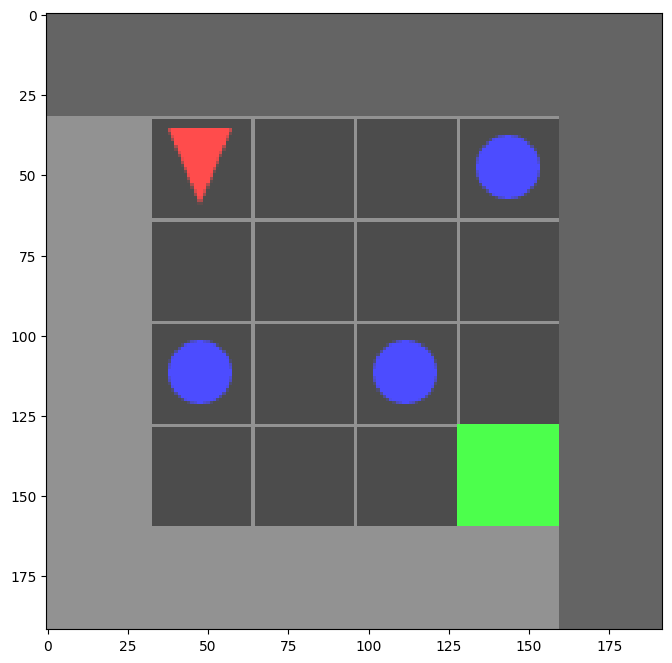

In [6]:
# 🎮 Take a single step in the environment using a random action

# Sample a random action from the environment's action space
action = env.action_space.sample()

# Apply the action using the step() function
# This returns the next observation, the reward, and flags indicating whether the episode has ended
observation, reward, terminated, truncated, info = env.step(action)
print(f"observation keys: {observation.keys()}")
print(f"observation shape: {observation['image'].shape}")
print(f"reward: {reward}")
print(f"terminated: {terminated}")
print(f"truncated: {truncated}")
print(f"info: {info}")
# Render the current frame (as an RGB image array)
screen = env.render()

# Note: In the rendered image, the grid shows the full environment.
# The small *highlighted square* around the agent indicates its **partial field of view** (7×7 grid)
# which is what the agent would observe in the default (non-wrapped) environment.

# Display the rendered image (works in Jupyter notebooks)
screen
plt.imshow(screen)
pass

### Save fig

In [7]:
#Random action plus visualization
#env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()
video_filename = '/content/fn.mp4'
max_steps = 100

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(48):
      action = env.action_space.sample()
      observation, reward, terminated, truncated, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

## Your code here ....

In [8]:
# ================================
# Cell 8 (revised) – Reproducibility + Observation Pre-processing
# ================================

from typing import Hashable

# ------------------------------------------------------------------
# 1. Reproducibility helper
# ------------------------------------------------------------------
SEED: int = 42  # ⚠️ Change this per experiment to get a new RNG stream.

def set_global_seed(seed: int = SEED, env: gym.Env | None = None) -> None:
    """
    Put *all* relevant PRNGs under one seed so that runs are repeatable.
    """
    random.seed(seed)
    np.random.seed(seed)
    if env is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

# ------------------------------------------------------------------
# 2. Mini utility to access agent_dir safely
# ------------------------------------------------------------------
def get_agent_dir(env: gym.Env) -> int:
    """
    Return the agent's compass direction (0–3) regardless of Gym wrappers.
    """
    return env.unwrapped.agent_dir

# ------------------------------------------------------------------
# 3. Observation -> discrete state preprocessing (tunable)
# ------------------------------------------------------------------
USE_COLOR: bool = False          # Include color channel? was false
USE_STATE: bool = False          # Include door-state channel?
INCLUDE_AGENT_DIR: bool = True   # Append agent_dir to state key?
FLATTEN_MODE: str = 'tuple'      # 'tuple' | 'string' | 'int'

def preprocess_observation(
    obs: Dict[str, np.ndarray],
    agent_dir: int,
    use_color: bool = USE_COLOR,
    use_state: bool = USE_STATE,
    include_agent_dir: bool = INCLUDE_AGENT_DIR,
    flatten_mode: str = FLATTEN_MODE
) -> Hashable:
    """
    Convert the 7×7×3 MiniGrid 'image' observation + agent direction
    into a hashable state ID suitable for tabular RL.
    """
    img = obs['image']          # (7,7,3) uint8
    object_chan = img[..., 0]   # Always keep object IDs
    channels = [object_chan]

    if use_color:
        channels.append(img[..., 1])
    if use_state:
        channels.append(img[..., 2])

    stacked = np.stack(channels, axis=-1).reshape(-1)

    if include_agent_dir:
        stacked = np.append(stacked, agent_dir)

    if flatten_mode == 'tuple':
        state_id: Hashable = tuple(map(int, stacked))
    elif flatten_mode == 'string':
        state_id = ','.join(map(str, stacked.astype(int)))
    elif flatten_mode == 'int':
        state_id = hash(tuple(map(int, stacked)))
    else:
        raise ValueError(f"Unknown FLATTEN_MODE '{flatten_mode}'")

    return state_id

# ------------------------------------------------------------------
# 4. Quick self-test (silent if OK)
# ------------------------------------------------------------------
if __name__ == "__main__":
    test_env = gym.make("MiniGrid-Dynamic-Obstacles-5x5-v0")
    set_global_seed(SEED, test_env)
    obs, _ = test_env.reset()
    test_state = preprocess_observation(obs, get_agent_dir(test_env))
    assert isinstance(test_state, Hashable)
    print("Sample preprocessed state:", str(test_state)[:60], "… OK")


Sample preprocessed state: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, … OK


In [9]:
# ================================
# Cell 9 – Generic Tabular RL Utilities
# ================================

from typing import Callable

# -------------------------------------------------
# 1.  Hyper-parameters (can override later)
# -------------------------------------------------
ALPHA: float = 0.10          # Learning rate
GAMMA: float = 0.99          # Discount factor

EPS_START: float = 1.0       # ε at episode 0
EPS_MIN: float   = 0.05      # minimum ε
EPS_DECAY: float = 0.995     # multiplicative decay (if using 'exp')
DECAY_TYPE: str  = 'exp'     # 'exp' | 'linear'

# -------------------------------------------------
# 2.  Q-table factory
# -------------------------------------------------
def create_q_table(n_actions: int) -> DefaultDict[Hashable, np.ndarray]:
    """
    Returns a defaultdict that maps state_id -> Q-value vector.
    Unknown states are initialised to an all-zeros float32 array.
    """
    return defaultdict(lambda: np.zeros(n_actions, dtype=np.float32))

# -------------------------------------------------
# 3.  ε-greedy action selection
# -------------------------------------------------
def epsilon_greedy_action(q_table: DefaultDict[Hashable, np.ndarray],
                          state: Hashable,
                          n_actions: int,
                          epsilon: float) -> int:
    """
    Choose an action using ε-greedy strategy.

    Parameters
    ----------
    q_table : defaultdict
        The Q-table mapping states to value vectors.
    state : Hashable
        Current state ID.
    n_actions : int
        Size of the discrete action space.
    epsilon : float
        Exploration probability.

    Returns
    -------
    action : int
        An action index in [0, n_actions-1].
    """
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)

    # This way we don't get stuck in a max state that we get, we choose random of best states
    q_row = q_table[state]
    best = np.flatnonzero(q_row == q_row.max())   # all max-valued actions
    return np.random.choice(best)          # Explore
    #return int(np.argmax(q_table[state]))          # Exploit

# -------------------------------------------------
# 4.  Epsilon scheduler (call once per episode)
# -------------------------------------------------
def update_epsilon(epsilon: float,
                   eps_min: float,
                   eps_decay: float,
                   eps_start: float,
                   episode_idx: int,
                   total_episodes: int,
                   decay_type: str):
    """
    Generic ε scheduler that relies on the *agent's own* settings.
    """
    if decay_type == 'exp':
        return max(eps_min, epsilon * eps_decay)
    elif decay_type == 'linear':
        slope = (eps_start - eps_min) / max(1, total_episodes - 1)
        return max(eps_min, eps_start - slope * episode_idx)
    else:
        raise ValueError(f"Unknown decay_type '{decay_type}'")


In [10]:
# ================================
# Cell – Reward-Shaping Utilities
# ================================
# --- Hyper-parameters you can tweak quickly ---
USE_REWARD_SHAPING = False    # turn OFF / ON here
SHAPING_BETA       = 0.05    # scale factor (0 = no effect)

def _manhattan(p, q) -> int:
    return abs(p[0] - q[0]) + abs(p[1] - q[1])

def _find_goal_pos(env):
    """
    Return (x, y) of the Goal tile, compatible with any MiniGrid build.
    """
    uw = env.unwrapped
    # 1) Fast path – attribute exists
    if hasattr(uw, "goal_pos"):
        return uw.goal_pos

    # 2) Fallback – scan the grid
    for y in range(uw.height):
        for x in range(uw.width):
            tile = uw.grid.get(x, y)
            if tile is not None and tile.type == "goal":
                return (x, y)
    raise RuntimeError("Goal not found; check environment generation")

def _potential(env):
    """Φ(s) = –manhattan distance (agent, goal)."""
    agent_pos = env.unwrapped.agent_pos
    goal_pos  = _find_goal_pos(env)
    return - (abs(agent_pos[0] - goal_pos[0]) + abs(agent_pos[1] - goal_pos[1]))

def shaping_fn(prev_env, reward, new_env) -> float:
    """Add potential-based shaping to the raw reward."""
    if not USE_REWARD_SHAPING:
        return reward
    phi_prev = _potential(prev_env)
    phi_next = _potential(new_env)
    return reward + SHAPING_BETA * (GAMMA * phi_next - phi_prev)


In [11]:
# ================================
# Cell 10 – Tabular RL Agent Classes
# ================================
# -------------------------------------------------
# 0.  Base class (common logic)
# -------------------------------------------------
class TabularAgent(ABC):
    """
    Abstract tabular agent. Handles ε-greedy action selection, the Q-table,
    and generic episode bookkeeping. Subclasses override `_compute_td_target`.
    """
    def __init__(self,
                 n_actions: int,
                 alpha: float = ALPHA,
                 gamma: float = GAMMA,
                 eps_start: float = EPS_START,
                 eps_min: float   = EPS_MIN,
                 eps_decay: float = EPS_DECAY,
                 decay_type: str  = DECAY_TYPE):
        self.n_actions = n_actions
        self.alpha     = alpha
        self.gamma     = gamma

        # Exploration schedule
        self.epsilon     = eps_start
        self.eps_start   = eps_start
        self.eps_min     = eps_min
        self.eps_decay   = eps_decay
        self.decay_type  = decay_type

        # Q-table initialisation
        self.Q: DefaultDict[Hashable, np.ndarray] = create_q_table(n_actions)

        # Stats
        self.episode_returns: List[float] = []
        self.episode_lengths: List[int]   = []
        self.success_flags: List[int]  = []   # 1 if reached goal, else 0
        self.eps_history  : List[float] = []  # ε after each episode


    # ------------- Public API -------------
    def act(self, state: Hashable) -> int:
        """Return an action index using current ε."""
        return epsilon_greedy_action(self.Q, state, self.n_actions, self.epsilon)

    def learn(self,
              env: gym.Env,
              num_episodes: int,
              preprocess_obs_fn,
              seed: int | None = None,
              render_every: int | None = None) -> None:
        """
        Run the learning loop for `num_episodes`.
        Stores total reward and length per episode.
        """

        if seed is not None:
            set_global_seed(seed, env)

        for ep in range(num_episodes):
            obs, _ = env.reset()
            state  = preprocess_obs_fn(obs, get_agent_dir(env))

            done, trun = False, False
            ep_return, t = 0.0, 0

            # Choose first action (needed for SARSA)
            action = self.act(state)

            while not (done or trun):
                next_obs, raw_reward, done, trun, _ = env.step(action)
                reward = shaping_fn(env, raw_reward, env)      # add shaping
                next_state = preprocess_obs_fn(next_obs, get_agent_dir(env))
                next_action = self.act(next_state)  # May be ignored by Q-learning

                # === Core update ===
                self._update_q(state, action, reward, next_state, next_action)

                state, action = next_state, next_action
                ep_return += reward
                t += 1

                if render_every and ep % render_every == 0:
                    env.render()

            # Bookkeeping & ε-decay
            self.episode_returns.append(ep_return)
            self.episode_lengths.append(t)
            self.success_flags.append(int(reward > 0))   # MiniGrid gives +1 on success
            self.eps_history.append(self.epsilon)
            self.epsilon = self.epsilon = update_epsilon(
                                                    self.epsilon,
                                                    self.eps_min,
                                                    self.eps_decay,
                                                    self.eps_start,
                                                    ep,
                                                    num_episodes,
                                                    self.decay_type
                                            )

    # ------------- Internal helpers -------------
    def _update_q(self,
                  s: Hashable,
                  a: int,
                  r: float,
                  s_next: Hashable,
                  a_next: int | None):
        """
        Generic Q update: Q[s,a] ← Q[s,a] + α (TD_target − Q[s,a])
        TD_target defined by subclass.
        """
        td_target = self._compute_td_target(r, s_next, a_next)
        td_error  = td_target - self.Q[s][a]
        self.Q[s][a] += self.alpha * td_error

    @abstractmethod
    def _compute_td_target(self,
                           r: float,
                           s_next: Hashable,
                           a_next: int | None) -> float:
        """Return the TD target for the specific algorithm."""
        ...

# -------------------------------------------------
# 1.  Q-learning (off-policy, uses max_a' Q(s',a'))
# -------------------------------------------------
class QLearningAgent(TabularAgent):
    def _compute_td_target(self,
                           r: float,
                           s_next: Hashable,
                           a_next: int | None) -> float:
        max_q_next = np.max(self.Q[s_next])
        return r + self.gamma * max_q_next

# -------------------------------------------------
# 2.  SARSA (on-policy, uses Q(s', a_next))
# -------------------------------------------------
class SARSAAgent(TabularAgent):
    def _compute_td_target(self,
                           r: float,
                           s_next: Hashable,
                           a_next: int | None) -> float:
        return r + self.gamma * self.Q[s_next][a_next]


▶ Training QLearningAgent for 5000 episodes…
   ✓ Q-table saved → models/QLearningAgent_Q.pkl
▶ Training SARSAAgent for 5000 episodes…
   ✓ Q-table saved → models/SARSAAgent_Q.pkl


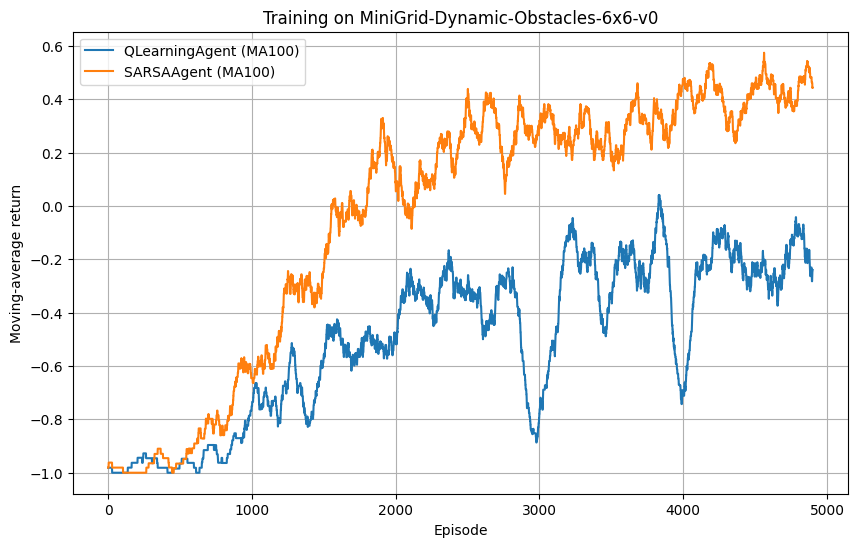

In [12]:
# ================================
# Cell 11 – Training Driver + Saving Pickle-friendly Q-tables
# ================================
import pickle
from typing import Type
from pathlib import Path

# -------------------------------------------------
# 0.  Helper: defaultdict → plain dict (pickle-safe)
# -------------------------------------------------
def qtable_to_plain(qtable) -> dict:
    """
    Replace defaultdict(lambda: zeros) with a plain dict whose values are
    *copies* of the numpy rows.  Necessary because pickling lambdas fails.
    """
    return {k: np.array(v) for k, v in qtable.items()}

def save_qtable(qtable, filepath: Path) -> None:
    """Serialize a Q-table after stripping the lambda."""
    filepath.parent.mkdir(exist_ok=True)
    with filepath.open("wb") as f:
        pickle.dump(qtable_to_plain(qtable), f)

# -------------------------------------------------
# CONFIGS – per-agent hyper-parameters
# -------------------------------------------------
CONFIGS = {
    "QLearningAgent": {
        "alpha": 0.05,
        "eps_decay": 0.995
    },
    "SARSAAgent": {
        # uses defaults
    }
}

# -------------------------------------------------
# 1.  Moving-average for smoother curves
# -------------------------------------------------
def moving_average(x: list[float], window: int = 100) -> np.ndarray:
    if len(x) < window:
        return np.array(x)
    return np.convolve(x, np.ones(window) / window, mode='valid')

# -------------------------------------------------
# 2.  Training factory
# -------------------------------------------------
def run_training(agent_cls: Type[TabularAgent],
                 env_name: str,
                 num_episodes: int,
                 seed: int = SEED,
                 **agent_kwargs) -> Tuple[TabularAgent, dict[str, list]]:
    env = gym.make(env_name, render_mode="rgb_array")
    agent = agent_cls(env.action_space.n, **agent_kwargs)

    agent.learn(env,
                num_episodes=num_episodes,
                preprocess_obs_fn=preprocess_observation,
                seed=seed)

    env.close()
    logs = {
    'returns'  : agent.episode_returns,
    'lengths'  : agent.episode_lengths,
    'success'  : agent.success_flags,
    'eps'      : agent.eps_history,
    }
    return agent, logs

# -------------------------------------------------
# 3.  Config (easy to tweak)
# -------------------------------------------------
ENV_NAME          = "MiniGrid-Dynamic-Obstacles-6x6-v0"
BONUS_ENV_NAME          = "MiniGrid-Dynamic-Obstacles-8x8-v0"
ENV_NAME = ENV_NAME # comment out if not bonus

NUM_EPISODES      = 5_000        # Raise for final runs (e.g., 20_000+)
MOVING_AVG_WINDOW = 100
MODEL_DIR         = Path("models")

# -------------------------------------------------
# 4.  Train agents, save Q-tables, plot learning curves
# -------------------------------------------------
plt.figure(figsize=(10, 6))
saarsa_log = []
qlearn_log = []
for agent_cls in [QLearningAgent, SARSAAgent]:
    name        = agent_cls.__name__
    kwargs      = CONFIGS.get(name, {})          #  ### NEW ###
    print(f"▶ Training {agent_cls.__name__} for {NUM_EPISODES} episodes…")
    agent, logs = run_training(agent_cls,
                               ENV_NAME,
                               NUM_EPISODES,
                               seed=SEED,
                               **kwargs)
    if agent_cls.__name__ == "SARSAAgent":
        saarsa_log = logs
    else:
        qlearn_log = logs

    # ---- Save policy for Evaluation Notebook ----
    fname = MODEL_DIR / f"{agent_cls.__name__}_Q.pkl"
    save_qtable(agent.Q, fname)
    print(f"   ✓ Q-table saved → {fname}")

    # ---- Plot learning curve ----
    rewards_ma = moving_average(logs['returns'], MOVING_AVG_WINDOW)
    plt.plot(rewards_ma, label=f"{agent_cls.__name__} (MA{MOVING_AVG_WINDOW})")

plt.title(f"Training on {ENV_NAME}")
plt.xlabel("Episode")
plt.ylabel("Moving-average return")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# ================================
# Cell – Full Metrics Visualisation
# ================================
def plot_all(logs, window=100):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # 1) Rewards
    ax[0].plot(moving_average(logs['returns'], window))
    ax[0].set_ylabel(f"Return (MA{window})")

    # 2) Success %
    ax[1].plot(moving_average(logs['success'], window))
    ax[1].set_ylabel(f"Success (MA{window})")

    # 3) ε decay
    ax[2].plot(logs['eps'])
    ax[2].set_ylabel("ε")
    ax[2].set_xlabel("Episode")

    plt.grid(True, axis='x')
    plt.show()


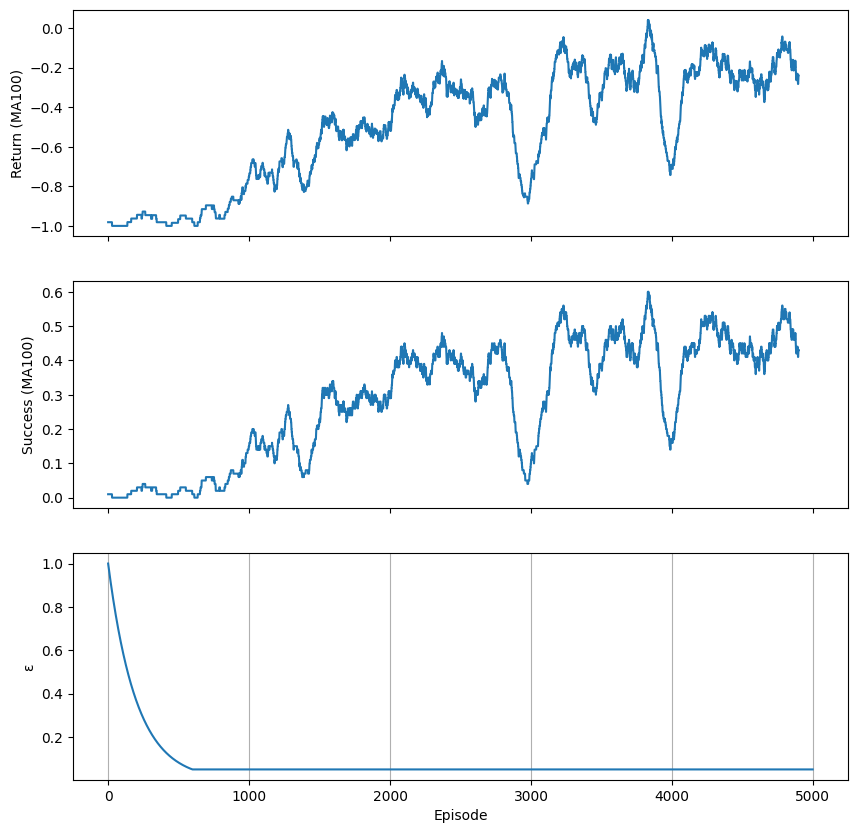

In [14]:
plot_all(qlearn_log)

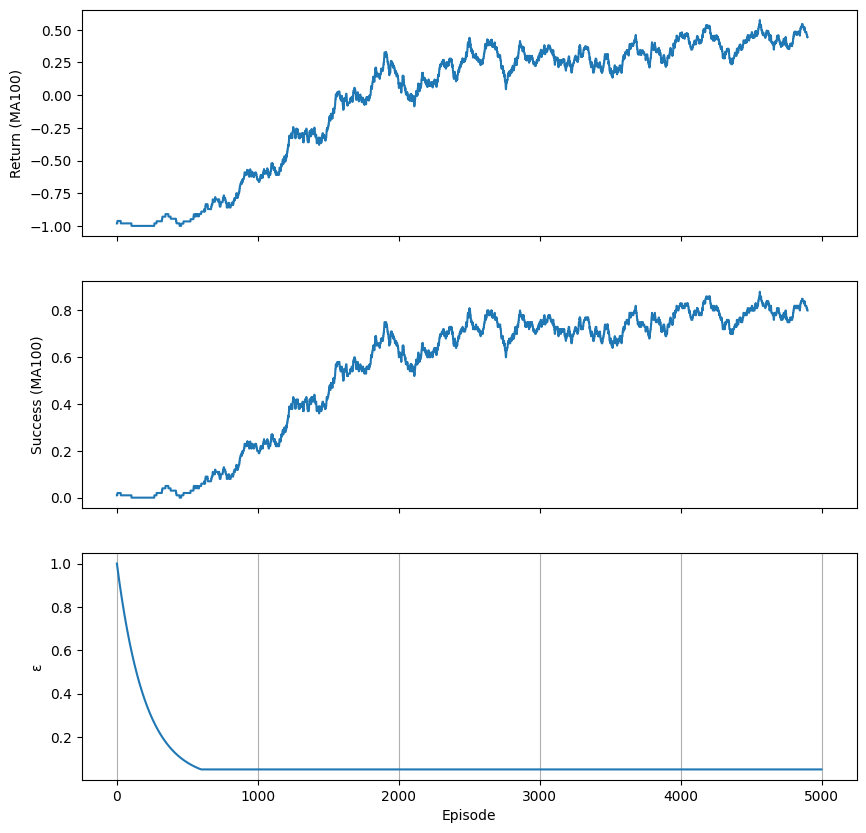

In [15]:
plot_all(saarsa_log)

In [16]:
# ================================
# Cell 12 – Visualise a Greedy Episode
# ================================

import imageio
from pathlib import Path

AGENT_NAME   = "SARSAAgent"          # or "QLearningAgent" | "SARSAAgent"
MODEL_DIR    = Path("models")
VIDEO_NAME   = f"{AGENT_NAME}_demo.mp4"
MAX_STEPS    = 480                   # safety cap

# -------------------------------------------------
# 1.  Load Q-table & recreate the agent instance
# -------------------------------------------------
# Helper to restore a pickled plain-dict Q-table into our defaultdict format
def load_agent(agent_name: str):
    # Pick algorithm class
    cls = SARSAAgent if agent_name == "SARSAAgent" else QLearningAgent
    # Rebuild empty agent
    dummy_env = gym.make(ENV_NAME)
    agent = cls(dummy_env.action_space.n)
    dummy_env.close()

    # Load plain dict, move into agent.Q
    import pickle, numpy as np
    q_path = MODEL_DIR / f"{agent_name}_Q.pkl"
    with q_path.open("rb") as f:
        plain_q = pickle.load(f)
    agent.Q = defaultdict(lambda: np.zeros(agent.n_actions, dtype=np.float32),
                          plain_q)
    agent.epsilon = 0.0   # greedy
    return agent

agent = load_agent(AGENT_NAME)

# -------------------------------------------------
# 2.  Run one greedy episode and collect frames
# -------------------------------------------------
env = gym.make(ENV_NAME, render_mode="rgb_array")
set_global_seed(SEED + 123, env)           # new seed for variety

obs, _   = env.reset()
state    = preprocess_observation(obs, get_agent_dir(env))
frames   = [env.render()]

for step in range(MAX_STEPS):
    action = int(np.argmax(agent.Q[state]))          # greedy action
    obs, reward, done, trunc, _ = env.step(action)
    frames.append(env.render())

    if done or trunc:
        print(AGENT_NAME)
        print(ENV_NAME)
        print(f"Episode finished in {step+1} steps, reward={reward:.2f}")
        break

    state = preprocess_observation(obs, get_agent_dir(env))

env.close()

# -------------------------------------------------
# 3.  Save → MP4 and embed
# -------------------------------------------------
with imageio.get_writer(VIDEO_NAME, fps=10) as video:
    for frame in frames:
        video.append_data(frame)
print(f"Video saved → {VIDEO_NAME}")

embed_mp4(VIDEO_NAME)


SARSAAgent
MiniGrid-Dynamic-Obstacles-6x6-v0
Episode finished in 25 steps, reward=0.84
Video saved → SARSAAgent_demo.mp4


In [17]:
AGENT_NAME   = "QLearningAgent"          # or "QLearningAgent" | "SARSAAgent"
MODEL_DIR    = Path("models")
VIDEO_NAME   = f"{AGENT_NAME}_demo.mp4"
MAX_STEPS    = 480                   # safety cap

agent = load_agent(AGENT_NAME)

# -------------------------------------------------
# 2.  Run one greedy episode and collect frames
# -------------------------------------------------
env = gym.make(ENV_NAME, render_mode="rgb_array")
set_global_seed(SEED + 123, env)           # new seed for variety

obs, _   = env.reset()
state    = preprocess_observation(obs, get_agent_dir(env))
frames   = [env.render()]

for step in range(MAX_STEPS):
    action = int(np.argmax(agent.Q[state]))          # greedy action
    obs, reward, done, trunc, _ = env.step(action)
    frames.append(env.render())

    if done or trunc:
        print(AGENT_NAME)
        print(ENV_NAME)
        print(f"Episode finished in {step+1} steps, reward={reward:.2f}")
        break

    state = preprocess_observation(obs, get_agent_dir(env))

env.close()

# -------------------------------------------------
# 3.  Save → MP4 and embed
# -------------------------------------------------
with imageio.get_writer(VIDEO_NAME, fps=10) as video:
    for frame in frames:
        video.append_data(frame)
print(f"Video saved → {VIDEO_NAME}")

embed_mp4(VIDEO_NAME)


QLearningAgent
MiniGrid-Dynamic-Obstacles-6x6-v0
Episode finished in 69 steps, reward=0.57
Video saved → QLearningAgent_demo.mp4



===== QLearningAgent (n=100) =====
           mean     std  median   min      max
reward    0.536   0.270   0.612   0.0    0.906
steps    72.430  39.865  62.000  15.0  144.000
success   0.890   0.314   1.000   0.0    1.000


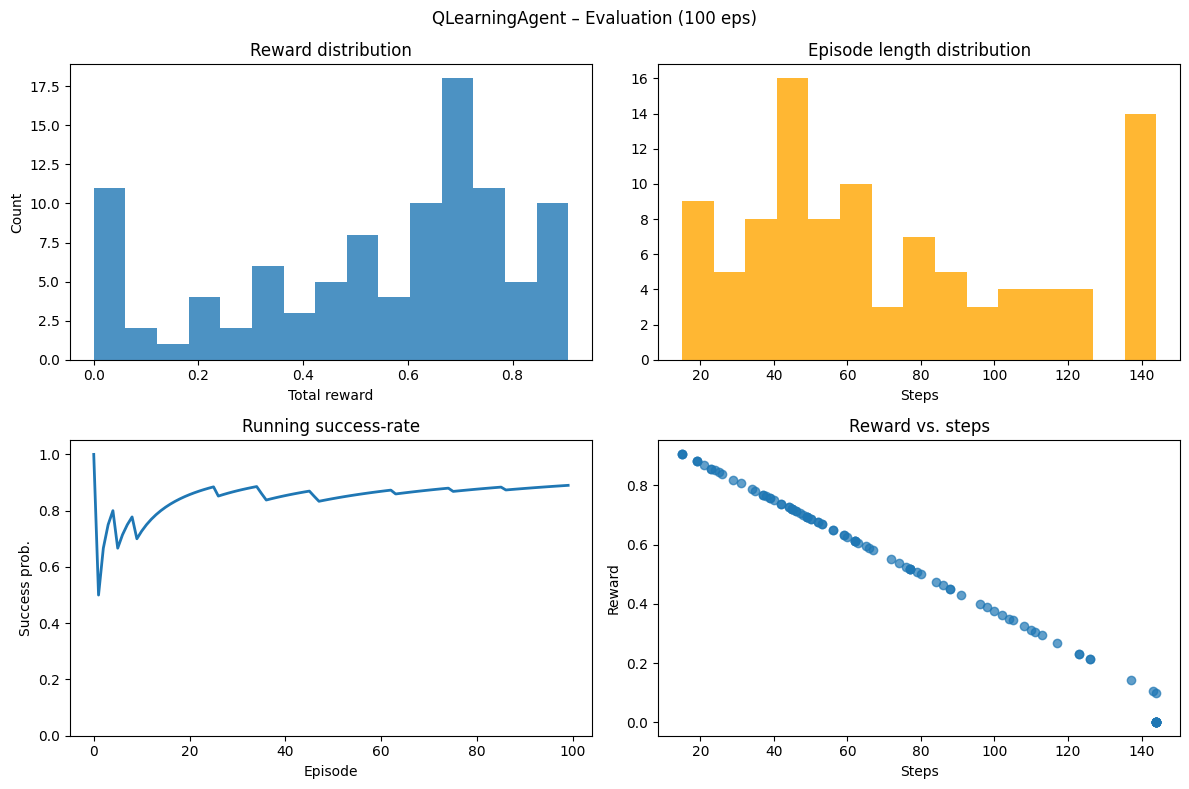


===== SARSAAgent (n=100) =====
           mean     std  median     min      max
reward    0.791   0.115   0.819   0.275    0.931
steps    33.520  18.388  29.000  11.000  116.000
success   1.000   0.000   1.000   1.000    1.000


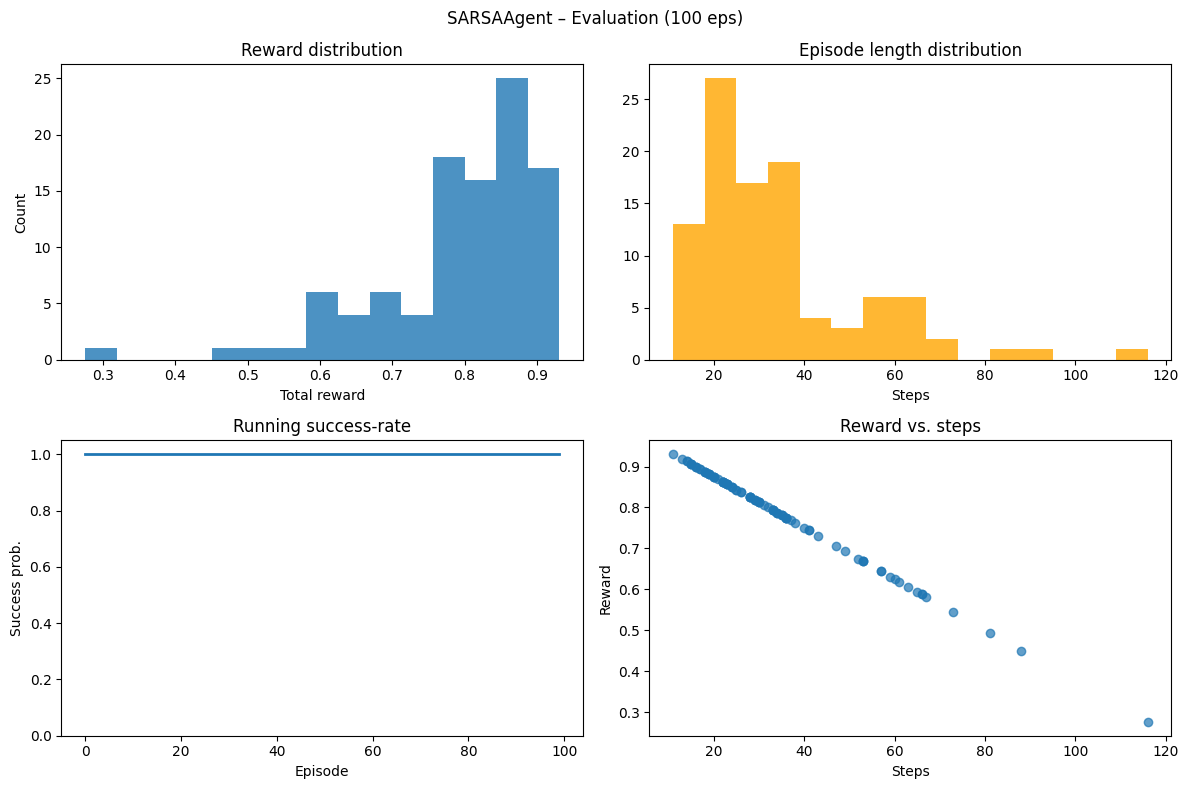

In [18]:
# ================================
# Cell — Comprehensive 100-Episode Evaluation
# ================================
import pandas as pd
import itertools

def evaluate_agent(agent, env_name: str, n_eps: int = 100, seed_offset: int = 99):
    """Return dict of lists: reward, steps, success(0/1) for n_eps episodes."""
    env = gym.make(env_name, render_mode="rgb_array")
    set_global_seed(SEED + seed_offset, env)
    agent.epsilon = 0.0          # greedy

    metrics = defaultdict(list)
    for ep in range(n_eps):
        obs, _ = env.reset()
        state  = preprocess_observation(obs, get_agent_dir(env))
        done = trun = False
        total_r = 0.0
        steps = 0
        while not (done or trun):
            a = int(np.argmax(agent.Q[state]))
            obs, r, done, trun, _ = env.step(a)
            state = preprocess_observation(obs, get_agent_dir(env))
            total_r += r
            steps += 1
        metrics["reward"].append(total_r)
        metrics["steps"].append(steps)
        metrics["success"].append(int(r > 0))

    env.close()
    return metrics


# ---------- Load, evaluate, and plot ----------
AGENTS = ["QLearningAgent", "SARSAAgent"]           # add more names if needed
EVAL_EPISODES = 100
results = {}                                        # store per-agent metrics

for name in AGENTS:
    # ----- reload Q-table -----
    pkl = Path("models") / f"{name}_Q.pkl"
    with pkl.open("rb") as f:
        q_plain = pickle.load(f)
    dummy_env = gym.make(ENV_NAME)
    AgentCls  = globals()[name]                     # class object
    agent     = AgentCls(dummy_env.action_space.n)
    agent.Q   = defaultdict(lambda: np.zeros(agent.n_actions, dtype=np.float32), q_plain)
    dummy_env.close()

    # ----- evaluate -----
    metrics = evaluate_agent(agent, ENV_NAME, n_eps=EVAL_EPISODES)
    results[name] = metrics

    # ----- summary stats -----
    df = pd.DataFrame(metrics)
    summary = df.agg(['mean','std','median','min','max']).T
    print(f"\n===== {name} (n={EVAL_EPISODES}) =====")
    print(summary.round(3))

    # ----- visual dashboard -----
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"{name} – Evaluation ({EVAL_EPISODES} eps)")

    # 1) reward histogram
    axs[0,0].hist(metrics["reward"], bins=15, alpha=0.8)
    axs[0,0].set_title("Reward distribution")
    axs[0,0].set_xlabel("Total reward"); axs[0,0].set_ylabel("Count")

    # 2) steps histogram
    axs[0,1].hist(metrics["steps"], bins=15, alpha=0.8, color='orange')
    axs[0,1].set_title("Episode length distribution")
    axs[0,1].set_xlabel("Steps")

    # 3) cumulative success curve
    cum_succ = np.cumsum(metrics["success"]) / np.arange(1, EVAL_EPISODES+1)
    axs[1,0].plot(cum_succ, lw=2)
    axs[1,0].set_ylim(0,1.05)
    axs[1,0].set_title("Running success-rate")
    axs[1,0].set_xlabel("Episode"); axs[1,0].set_ylabel("Success prob.")

    # 4) reward vs steps scatter
    axs[1,1].scatter(metrics["steps"], metrics["reward"], alpha=0.7)
    axs[1,1].set_title("Reward vs. steps")
    axs[1,1].set_xlabel("Steps"); axs[1,1].set_ylabel("Reward")

    plt.tight_layout()
    plt.show()


**Bonus**

In [ ]:
# -------------------------------------------------
# CONFIGS – per-agent hyper-parameters - Bonus
# -------------------------------------------------
CONFIGS = {
    "QLearningAgent": {
        "alpha": 0.05,
        "eps_decay": 0.995
    },
    "SARSAAgent": {
        # uses defaults
    }
}

# -------------------------------------------------
# 3.  Config (easy to tweak)
# -------------------------------------------------
ENV_NAME          = "MiniGrid-Dynamic-Obstacles-6x6-v0"
BONUS_ENV_NAME          = "MiniGrid-Dynamic-Obstacles-8x8-v0"
ENV_NAME = BONUS_ENV_NAME

NUM_EPISODES      = 50_000        # Raise for final runs (e.g., 20_000+)
MOVING_AVG_WINDOW = 100
MODEL_DIR         = Path("models")

# -------------------------------------------------
# 4.  Train agents, save Q-tables, plot learning curves
# -------------------------------------------------
plt.figure(figsize=(10, 6))
saarsa_log = []
qlearn_log = []
for agent_cls in [QLearningAgent, SARSAAgent]:
    name        = agent_cls.__name__
    kwargs      = CONFIGS.get(name, {})          #  ### NEW ###
    print(f"▶ Training {agent_cls.__name__} for {NUM_EPISODES} episodes…")
    agent, logs = run_training(agent_cls,
                               ENV_NAME,
                               NUM_EPISODES,
                               seed=SEED,
                               **kwargs)
    if agent_cls.__name__ == "SARSAAgent":
        saarsa_log = logs
    else:
        qlearn_log = logs

    # ---- Save policy for Evaluation Notebook ----
    fname = MODEL_DIR / f"{agent_cls.__name__}_Q.pkl"
    save_qtable(agent.Q, fname)
    print(f"   ✓ Q-table saved → {fname}")

    # ---- Plot learning curve ----
    rewards_ma = moving_average(logs['returns'], MOVING_AVG_WINDOW)
    plt.plot(rewards_ma, label=f"{agent_cls.__name__} (MA{MOVING_AVG_WINDOW})")

plt.title(f"Training on {ENV_NAME}")
plt.xlabel("Episode")
plt.ylabel("Moving-average return")
plt.legend()
plt.grid(True)
plt.show()


▶ Training QLearningAgent for 50000 episodes…


In [ ]:
plot_all(qlearn_log)

In [ ]:
plot_all(saarsa_log)

In [ ]:
AGENT_NAME   = "QLearningAgent"          # or "QLearningAgent" | "SARSAAgent"
MODEL_DIR    = Path("models")
VIDEO_NAME   = f"{AGENT_NAME}_demo.mp4"
MAX_STEPS    = 260                   # safety cap

agent = load_agent(AGENT_NAME)

# -------------------------------------------------
# 2.  Run one greedy episode and collect frames
# -------------------------------------------------
env = gym.make(ENV_NAME, render_mode="rgb_array")
set_global_seed(SEED + 123, env)           # new seed for variety

obs, _   = env.reset()
state    = preprocess_observation(obs, get_agent_dir(env))
frames   = [env.render()]

for step in range(MAX_STEPS):
    action = int(np.argmax(agent.Q[state]))          # greedy action
    obs, reward, done, trunc, _ = env.step(action)
    frames.append(env.render())

    if done: print("done")
    if trunc: print("trunc")
    if done or trunc:
        print(AGENT_NAME)
        print(ENV_NAME)
        print(f"Episode finished in {step+1} steps, reward={reward:.2f}")
        break

    state = preprocess_observation(obs, get_agent_dir(env))

env.close()

# -------------------------------------------------
# 3.  Save → MP4 and embed
# -------------------------------------------------
with imageio.get_writer(VIDEO_NAME, fps=10) as video:
    for frame in frames:
        video.append_data(frame)
print(f"Video saved → {VIDEO_NAME}")

embed_mp4(VIDEO_NAME)


In [ ]:
AGENT_NAME   = "SARSAAgent"          # or "QLearningAgent" | "SARSAAgent"
MODEL_DIR    = Path("models")
VIDEO_NAME   = f"{AGENT_NAME}_demo.mp4"
MAX_STEPS    = 260                   # safety cap

agent = load_agent(AGENT_NAME)

# -------------------------------------------------
# 2.  Run one greedy episode and collect frames
# -------------------------------------------------
env = gym.make(ENV_NAME, render_mode="rgb_array")
set_global_seed(SEED + 123, env)           # new seed for variety

obs, _   = env.reset()
state    = preprocess_observation(obs, get_agent_dir(env))
frames   = [env.render()]

for step in range(MAX_STEPS):
    action = int(np.argmax(agent.Q[state]))          # greedy action
    obs, reward, done, trunc, _ = env.step(action)
    frames.append(env.render())
    if done: print("done")
    if trunc: print("trunc")
    if done or trunc:
        print(AGENT_NAME)
        print(ENV_NAME)
        print(f"Episode finished in {step+1} steps, reward={reward:.2f}")
        break

    state = preprocess_observation(obs, get_agent_dir(env))

env.close()

# -------------------------------------------------
# 3.  Save → MP4 and embed
# -------------------------------------------------
with imageio.get_writer(VIDEO_NAME, fps=10) as video:
    for frame in frames:
        video.append_data(frame)
print(f"Video saved → {VIDEO_NAME}")

embed_mp4(VIDEO_NAME)


In [ ]:
# ================================
# Cell — Comprehensive 100-Episode Evaluation
# ================================
# ---------- Load, evaluate, and plot ----------
AGENTS = ["QLearningAgent", "SARSAAgent"]           # add more names if needed
EVAL_EPISODES = 100
results = {}                                        # store per-agent metrics

for name in AGENTS:
    # ----- reload Q-table -----
    pkl = Path("models") / f"{name}_Q.pkl"
    with pkl.open("rb") as f:
        q_plain = pickle.load(f)
    dummy_env = gym.make(ENV_NAME)
    AgentCls  = globals()[name]                     # class object
    agent     = AgentCls(dummy_env.action_space.n)
    agent.Q   = defaultdict(lambda: np.zeros(agent.n_actions, dtype=np.float32), q_plain)
    dummy_env.close()

    # ----- evaluate -----
    metrics = evaluate_agent(agent, ENV_NAME, n_eps=EVAL_EPISODES)
    results[name] = metrics

    # ----- summary stats -----
    df = pd.DataFrame(metrics)
    summary = df.agg(['mean','std','median','min','max']).T
    print(f"\n===== {name} (n={EVAL_EPISODES}) =====")
    print(summary.round(3))

    # ----- visual dashboard -----
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"{name} – Evaluation ({EVAL_EPISODES} eps)")

    # 1) reward histogram
    axs[0,0].hist(metrics["reward"], bins=15, alpha=0.8)
    axs[0,0].set_title("Reward distribution")
    axs[0,0].set_xlabel("Total reward"); axs[0,0].set_ylabel("Count")

    # 2) steps histogram
    axs[0,1].hist(metrics["steps"], bins=15, alpha=0.8, color='orange')
    axs[0,1].set_title("Episode length distribution")
    axs[0,1].set_xlabel("Steps")

    # 3) cumulative success curve
    cum_succ = np.cumsum(metrics["success"]) / np.arange(1, EVAL_EPISODES+1)
    axs[1,0].plot(cum_succ, lw=2)
    axs[1,0].set_ylim(0,1.05)
    axs[1,0].set_title("Running success-rate")
    axs[1,0].set_xlabel("Episode"); axs[1,0].set_ylabel("Success prob.")

    # 4) reward vs steps scatter
    axs[1,1].scatter(metrics["steps"], metrics["reward"], alpha=0.7)
    axs[1,1].set_title("Reward vs. steps")
    axs[1,1].set_xlabel("Steps"); axs[1,1].set_ylabel("Reward")

    plt.tight_layout()
    plt.show()
